[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sepehr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sepehr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


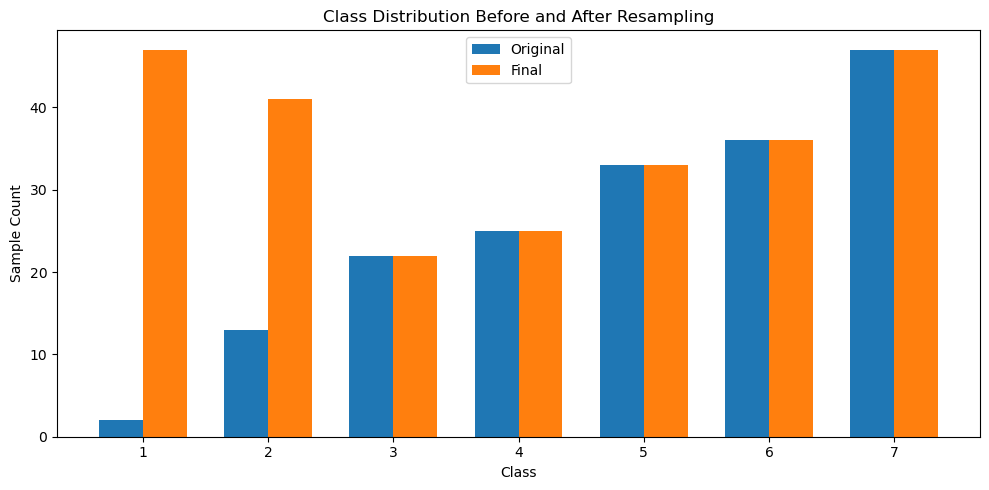

Train Accuracy: 1.0
Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00        10

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51


Running 5-fold cross-validation...
Mean Accuracy: 0.9961 +/- 0.0078
Mean F1 Macro: 0.9949 +/- 0.0102

Running Leave-One-Out Cross-Validation (LOOCV)...
LOOCV Accuracy: 0.9960 +/- 0.0630
LOOCV F1 Macro: 0.9960 +/- 0.0630

Accuracy Matrix (3-class labels):
          Nathan  judges  Dreamers
Nathan     1.000   0.514     0.049
judges     0.

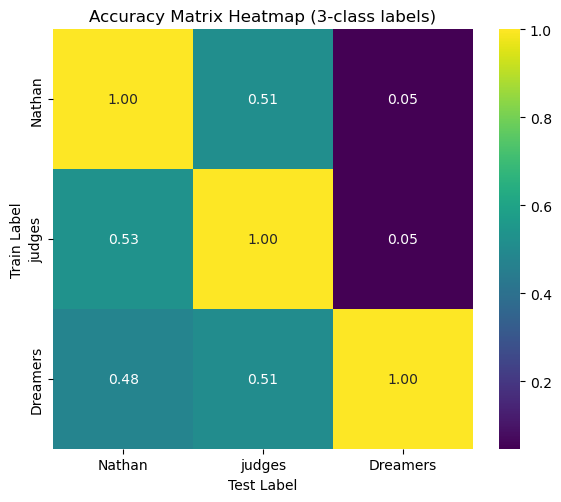


Cohen's Kappa Matrix (3-class labels):
          Nathan  judges  Dreamers
Nathan     1.000   0.846     0.099
judges     0.846   1.000     0.059
Dreamers   0.099   0.059     1.000


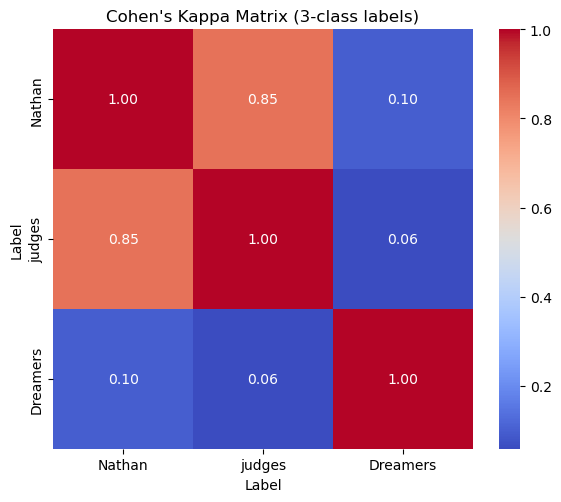


Spearman Correlation Matrix (3-class labels):
          Nathan  judges  Dreamers
Nathan     1.000   0.885     0.260
judges     0.885   1.000     0.237
Dreamers   0.260   0.237     1.000


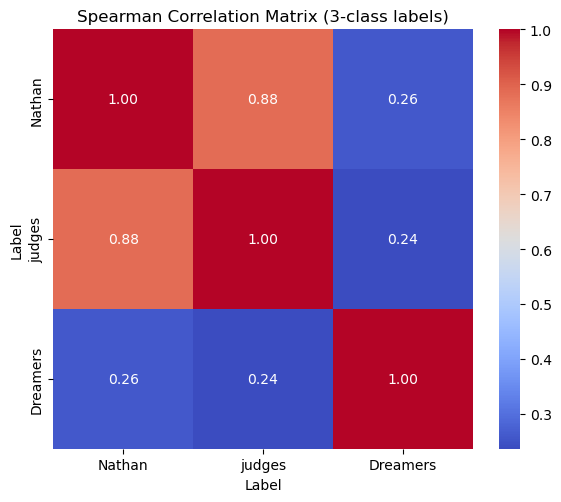


Accuracy Matrix (7-class labels):
           sentiment  Nathan7
sentiment      1.000    0.044
Nathan7        0.157    1.000


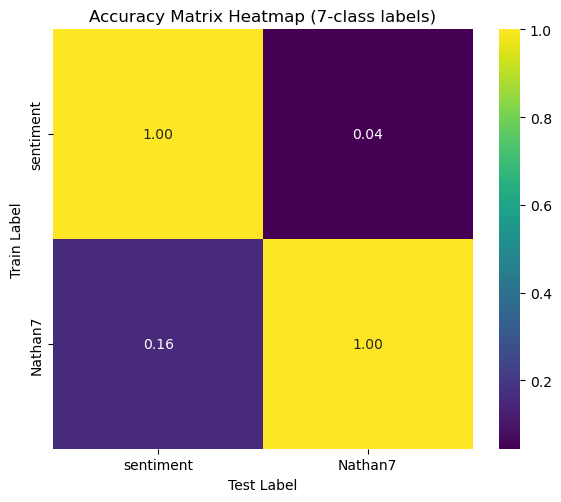


Spearman Correlation Matrix (7-class labels):
           sentiment  Nathan7
sentiment      1.000    0.171
Nathan7        0.171    1.000


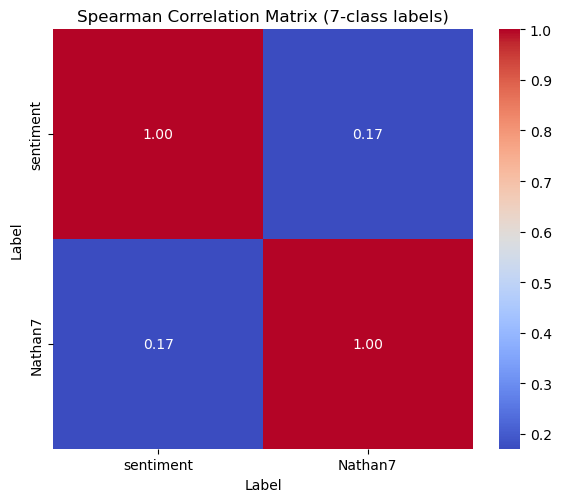

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from empath import Empath
import nltk
import seaborn as sns

# Setup
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
lexicon = Empath()

# Load data
df = pd.read_csv("/Users/sepehr/Desktop/Thesis/Dataset.csv")

# Preprocess text
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words])

df["cleaned_text"] = df["text"].apply(preprocess_text)
df = df[df["cleaned_text"].str.strip().astype(bool)]
df = df.dropna(subset=["sentiment"])
y = df["sentiment"].astype(int)

# Extract features: Empath + TF-IDF
empath_features = df["cleaned_text"].apply(lambda x: pd.Series(lexicon.analyze(x, normalize=True)))
df_combined = pd.concat([df.reset_index(drop=True), empath_features.reset_index(drop=True)], axis=1).fillna(0)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_features=1000)
X_tfidf = vectorizer.fit_transform(df_combined["cleaned_text"]).toarray()
X = np.hstack((X_tfidf, df_combined[empath_features.columns].values))
X = StandardScaler().fit_transform(X)

# Save original distribution and samples
original_dist = y.value_counts().sort_index()
min_class_size = original_dist.min()
k_neighbors = min(3, min_class_size - 1)
saved_samples = {cls: (X[y == cls], y[y == cls]) for cls in original_dist.index}

# Apply SMOTEENN
smote_enn = SMOTEENN(smote=SMOTE(k_neighbors=k_neighbors), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
resampled_dist = pd.Series(y_resampled).value_counts().sort_index()

# Restore missing/underrepresented classes
X_extra, y_extra = [], []
missing_classes = set(original_dist.index) - set(resampled_dist.index)

for cls in missing_classes:
    original_n = original_dist[cls]
    X_cls, y_cls = saved_samples[cls]
    X_dup = np.repeat(X_cls[:1], original_n, axis=0)
    y_dup = np.repeat(y_cls[:1].values, original_n)
    X_extra.append(X_dup)
    y_extra.append(y_dup)

for cls in original_dist.index:
    if cls in missing_classes:
        continue
    original_n = original_dist[cls]
    current_n = resampled_dist.get(cls, 0)
    needed = original_n - current_n
    if needed > 0:
        X_cls, y_cls = saved_samples[cls]
        if len(X_cls) > 1:
            try:
                smote = SMOTE(sampling_strategy={cls: needed}, random_state=42, k_neighbors=1)
                X_aug, y_aug = smote.fit_resample(X_cls, y_cls)
                X_extra.append(X_aug[-needed:])
                y_extra.append(y_aug[-needed:])
            except:
                X_dup = np.repeat(X_cls[:1], needed, axis=0)
                y_dup = np.repeat(y_cls[:1].values, needed)
                X_extra.append(X_dup)
                y_extra.append(y_dup)
        elif len(X_cls) == 1:
            X_dup = np.repeat(X_cls[:1], needed, axis=0)
            y_dup = np.repeat(y_cls[:1].values, needed)
            X_extra.append(X_dup)
            y_extra.append(y_dup)

# Combine all
if X_extra:
    X_final = np.vstack([X_resampled] + X_extra)
    y_final = np.hstack([y_resampled] + y_extra)
else:
    X_final, y_final = X_resampled, y_resampled

# Plot class distribution
def plot_distribution(before, after, label="Final"):
    plt.figure(figsize=(10, 5))
    all_classes = sorted(set(before.index).union(after.index))
    indices = np.arange(len(all_classes))
    bar_width = 0.35
    plt.bar(indices, [before.get(i, 0) for i in all_classes], width=bar_width, label='Original')
    plt.bar(indices + bar_width, [after.get(i, 0) for i in all_classes], width=bar_width, label=label)
    plt.xticks(indices + bar_width / 2, all_classes)
    plt.xlabel("Class")
    plt.ylabel("Sample Count")
    plt.title("Class Distribution Before and After Resampling")
    plt.legend()
    plt.tight_layout()
    plt.savefig("class_distribution.png")
    plt.show()

plot_distribution(original_dist, pd.Series(y_final).value_counts().sort_index(), "Final")

# Train and evaluate model
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
model = MLPClassifier(hidden_layer_sizes=100, alpha=0.0005, max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy reports
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


# 5-fold CV
print("\nRunning 5-fold cross-validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(model, X_final, y_final, cv=skf, scoring='accuracy')
f1_scores = cross_val_score(model, X_final, y_final, cv=skf, scoring=make_scorer(f1_score, average='macro'))
print(f"Mean Accuracy: {acc_scores.mean():.4f} +/- {acc_scores.std():.4f}")
print(f"Mean F1 Macro: {f1_scores.mean():.4f} +/- {f1_scores.std():.4f}")

# LOOCV
print("\nRunning Leave-One-Out Cross-Validation (LOOCV)...")
loo = LeaveOneOut()
acc_loo = cross_val_score(model, X_final, y_final, cv=loo, scoring='accuracy')
f1_loo = cross_val_score(model, X_final, y_final, cv=loo, scoring=make_scorer(f1_score, average='macro'))
print(f"LOOCV Accuracy: {acc_loo.mean():.4f} +/- {acc_loo.std():.4f}")
print(f"LOOCV F1 Macro: {f1_loo.mean():.4f} +/- {f1_loo.std():.4f}")

# --- ACCURACY & CORRELATION MATRICES FOR 3-CLASS AND 7-CLASS LABELS SEPARATELY ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr, spearmanr

# Rename 'giulia' to 'Dreamers' in the DataFrame and code
if 'giulia' in df.columns:
    df = df.rename(columns={'giulia': 'Dreamers'})

label_columns_3 = ["Nathan", "judges", "Dreamers"]
label_columns_7 = ["sentiment", "Nathan7"]

# Helper to get classes
get_classes = lambda col: len(np.unique(col.dropna()))

# Function to build resampled features/labels for a label column
def build_resampled(label, shift_nathan7=False):
    y_lbl = df[label].dropna().astype(int)
    if shift_nathan7 and label == "Nathan7":
        y_lbl = y_lbl + 1
    idx = y_lbl.index
    X_txt = df.loc[idx, "cleaned_text"]
    empath_features_lbl = X_txt.apply(lambda x: pd.Series(lexicon.analyze(x, normalize=True)))
    X_tfidf_lbl = vectorizer.transform(X_txt).toarray()
    X_lbl = np.hstack((X_tfidf_lbl, empath_features_lbl.values))
    X_lbl = StandardScaler().fit_transform(X_lbl)
    # Resample
    original_dist = y_lbl.value_counts().sort_index()
    min_class_size = original_dist.min()
    k_neighbors = min(3, min_class_size - 1) if min_class_size > 1 else 1
    saved_samples = {cls: (X_lbl[y_lbl == cls], y_lbl[y_lbl == cls]) for cls in original_dist.index}
    smote_enn = SMOTEENN(smote=SMOTE(k_neighbors=k_neighbors), random_state=42)
    X_res, y_res = smote_enn.fit_resample(X_lbl, y_lbl)
    resampled_dist = pd.Series(y_res).value_counts().sort_index()
    # Restore missing/underrepresented classes
    X_extra, y_extra = [], []
    missing_classes = set(original_dist.index) - set(resampled_dist.index)
    for cls in missing_classes:
        original_n = original_dist[cls]
        X_cls, y_cls = saved_samples[cls]
        X_dup = np.repeat(X_cls[:1], original_n, axis=0)
        y_dup = np.repeat(y_cls[:1].values, original_n)
        X_extra.append(X_dup)
        y_extra.append(y_dup)
    for cls in original_dist.index:
        if cls in missing_classes:
            continue
        original_n = original_dist[cls]
        current_n = resampled_dist.get(cls, 0)
        needed = original_n - current_n
        if needed > 0:
            X_cls, y_cls = saved_samples[cls]
            if len(X_cls) > 1:
                try:
                    smote = SMOTE(sampling_strategy={cls: needed}, random_state=42, k_neighbors=1)
                    X_aug, y_aug = smote.fit_resample(X_cls, y_cls)
                    X_extra.append(X_aug[-needed:])
                    y_extra.append(y_aug[-needed:])
                except:
                    X_dup = np.repeat(X_cls[:1], needed, axis=0)
                    y_dup = np.repeat(y_cls[:1].values, needed)
                    X_extra.append(X_dup)
                    y_extra.append(y_dup)
            elif len(X_cls) == 1:
                X_dup = np.repeat(X_cls[:1], needed, axis=0)
                y_dup = np.repeat(y_cls[:1].values, needed)
                X_extra.append(X_dup)
                y_extra.append(y_dup)
    if X_extra:
        X_final = np.vstack([X_res] + X_extra)
        y_final = np.hstack([y_res] + y_extra)
    else:
        X_final, y_final = X_res, y_res
    return X_final, y_final

# Function to compute and plot matrices for a group of label columns
def compute_and_plot_matrices(label_columns, shift_nathan7=False, group_name="", compute_kappa=True):
    # Build data for each label
    data_dict = {}
    for label in label_columns:
        data_dict[label] = build_resampled(label, shift_nathan7=shift_nathan7)
    # Accuracy matrix
    acc_matrix = pd.DataFrame(index=label_columns, columns=label_columns, dtype=float)
    for train_col in label_columns:
        for test_col in label_columns:
            X_train, y_train = data_dict[train_col]
            X_test, y_test = data_dict[test_col]
            min_len = min(len(y_train), len(y_test))
            X_train, y_train = X_train[:min_len], y_train[:min_len]
            X_test, y_test = X_test[:min_len], y_test[:min_len]
            clf = LogisticRegression(max_iter=200)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            acc_matrix.loc[train_col, test_col] = acc
    print(f"\nAccuracy Matrix ({group_name}):")
    print(acc_matrix.round(3))
    plt.figure(figsize=(6, 5))
    sns.heatmap(acc_matrix.astype(float), annot=True, fmt=".2f", cmap="viridis", cbar=True, square=True)
    plt.title(f"Accuracy Matrix Heatmap ({group_name})")
    plt.xlabel("Test Label")
    plt.ylabel("Train Label")
    plt.tight_layout()
    plt.show()
    # Correlation matrices
    if compute_kappa:
        kappa_matrix = pd.DataFrame(index=label_columns, columns=label_columns, dtype=float)
    spearman_matrix = pd.DataFrame(index=label_columns, columns=label_columns, dtype=float)
    for col1 in label_columns:
        for col2 in label_columns:
            valid_idx = df[[col1, col2]].dropna().index
            y1 = df.loc[valid_idx, col1].astype(int)
            y2 = df.loc[valid_idx, col2].astype(int)
            if shift_nathan7 and col1 == "Nathan7":
                y1 = y1 + 1
            if shift_nathan7 and col2 == "Nathan7":
                y2 = y2 + 1
            if compute_kappa:
                kappa = cohen_kappa_score(y1, y2)
                kappa_matrix.loc[col1, col2] = kappa
            try:
                spearman, _ = spearmanr(y1, y2)
            except Exception:
                spearman = np.nan
            spearman_matrix.loc[col1, col2] = spearman
    if compute_kappa:
        print(f"\nCohen's Kappa Matrix ({group_name}):")
        print(kappa_matrix.round(3))
        plt.figure(figsize=(6, 5))
        sns.heatmap(kappa_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
        plt.title(f"Cohen's Kappa Matrix ({group_name})")
        plt.xlabel("Label")
        plt.ylabel("Label")
        plt.tight_layout()
        plt.show()
    print(f"\nSpearman Correlation Matrix ({group_name}):")
    print(spearman_matrix.round(3))
    plt.figure(figsize=(6, 5))
    sns.heatmap(spearman_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title(f"Spearman Correlation Matrix ({group_name})")
    plt.xlabel("Label")
    plt.ylabel("Label")
    plt.tight_layout()
    plt.show()

# Run for 3-class and 7-class groups
compute_and_plot_matrices(label_columns_3, shift_nathan7=False, group_name="3-class labels", compute_kappa=True)
compute_and_plot_matrices(label_columns_7, shift_nathan7=True, group_name="7-class labels", compute_kappa=False)
